In [1]:
#importing
import numpy as np
import tifffile as tif
from tqdm import tqdm
import matplotlib.pyplot as plt
from textwrap import wrap

In [4]:
# loading gfp single_neuron tif file (t,z,1024,1024)
img_path = '/Users/aichah/Documents/TLI_analysis/input_data/211011_neuron1_gfp_clean.tif'
with tif.TiffFile(img_path) as tiff:
    neuron = tiff.asarray()
neuron[neuron!=0] = 1 #make sure image is binary

In [5]:
# load columns mask as 3D stack: each column in a slice
col_path = '/Users/aichah/Documents/TLI_analysis/input_data/211011_neuron1_columns.tif'
# load image
with tif.TiffFile(col_path) as tiff:
    cols = tiff.asarray()
cols.shape
cols[cols!=0] = 1

Claculating stable pixels and saving them as tif

In [7]:
# setting the number of timepoints required to classify stable pixels
stab_limit = 4

# croping the array to around the neuron to speed the runtime
img1 = neuron[:,:,630:950,670:1020]
# tif.imsave('211011_neuron1_gfp_all.tif', img1, imagej=True)

img2 = img1.copy()
# deleting unstabilized pixels: ones that don't remain at least an hour
for t in tqdm(np.arange(img1[stab_limit-1:].shape[0]), desc='filtering_px'):
    for z in np.arange(img1.shape[1]):
        for y in np.arange(img1.shape[2]):
            for x in np.arange(img1.shape[3]): 
                if img1[t:t+stab_limit,z,y,x].sum() < stab_limit:
                    img2[t+stab_limit-1,z,y,x] = 0

# make the first 4 timepoints the same (you can ignore first hour of analysis)
img2[0] = img2[3]
img2[1] = img2[3]
img2[2] = img2[3]

#make shape of neuron_stable image the same as original neuron array
neuron_stable = neuron.copy()
neuron_stable[:,:,630:950,670:1020] = img2


tif.imsave('../output/211011_neuron1_gfp_stabilized.tif', neuron_stable, imagej=True)

filtering_px: 100%|██████████| 82/82 [42:54<00:00, 31.40s/it]


Column Occupancy

calculating Col occupancy: 100%|██████████| 9/9 [01:51<00:00, 12.34s/it]


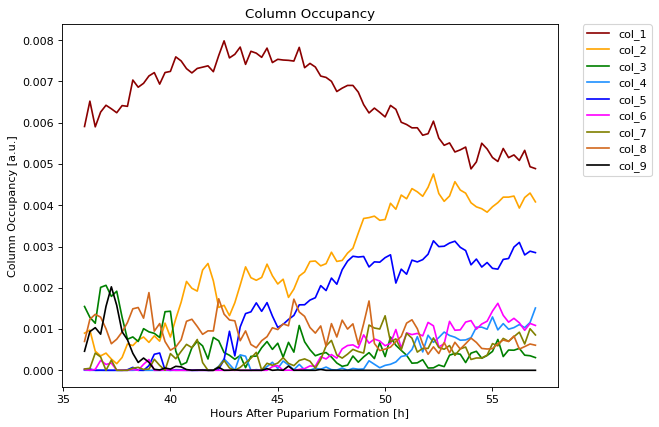

In [15]:
#### of all pixels
# calculate occupancy of each colmun as save them in dict
cols_hist = {}
ind = 0
for col in tqdm(cols, desc='calculating Col occupancy'):
    ind += 1
    cols_hist['col_'+str(ind)] = []
    filter = np.broadcast_to(col, neuron.shape)
    col_size = filter.sum()
    nue_sub = filter * neuron # pixels occupied by neuron in the column
    for t in tqdm(nue_sub, leave=False):
        cols_hist['col_'+str(ind)].append(t.sum()/col_size)

#normalize the occupancy based on maximum occupancy of home column (2) across timepoints
factor = neuron.sum()
for col, ocup in cols_hist.items():
    cols_hist[col] = ocup

colors = ['darkred', 'orange', 'green', 'dodgerblue', 'blue', 'magenta', 'olive', 'chocolate', 'black']
col_names = list(cols_hist.keys())
col_colors  = {}
for i in range(len(col_names)):
    col_colors[col_names[i]] = colors[i]

#ploting the results
from textwrap import wrap
timepoints = [36+(i*0.25) for i in np.arange(len(cols_hist['col_2']))]
plt.figure(figsize=(8, 6), dpi=80)
for col, val in cols_hist.items():
    plt.plot(timepoints, cols_hist[col], color=col_colors[col], label=col)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Column Occupancy')
plt.ylabel("\n".join(wrap('Column Occupancy [a.u.]',30)))
plt.xlabel("Hours After Puparium Formation [h]")
plt.savefig('../output/columns_occupancy.pdf', bbox_inches='tight')

calculating Col occupancy: 100%|██████████| 9/9 [01:58<00:00, 13.16s/it]


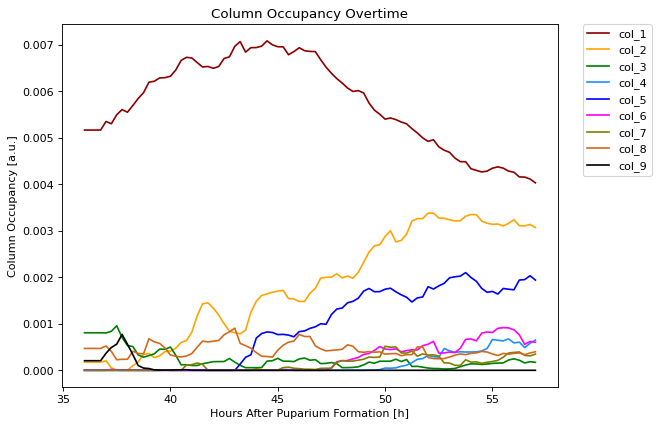

In [18]:
#### of stable pixels only
# calculate occupancy of each colmun as save them in dict
cols_hist = {}
ind = 0
for col in tqdm(cols, desc='calculating Col occupancy'):
    ind += 1
    cols_hist['col_'+str(ind)] = []
    filter = np.broadcast_to(col, neuron_stable.shape)
    col_size = filter.sum()
    nue_sub = filter * neuron_stable # pixels occupied by neuron in the column
    for t in tqdm(nue_sub, leave=False):
        cols_hist['col_'+str(ind)].append(t.sum()/col_size)

#normalize the occupancy based on maximum occupancy of home column (2) across timepoints
factor = neuron_stable.sum()
for col, ocup in cols_hist.items():
    cols_hist[col] = ocup

colors = ['darkred', 'orange', 'green', 'dodgerblue', 'blue', 'magenta', 'olive', 'chocolate', 'black']
col_names = list(cols_hist.keys())
col_colors  = {}
for i in range(len(col_names)):
    col_colors[col_names[i]] = colors[i]

#ploting the results
from textwrap import wrap
timepoints = [36+(i*0.25) for i in np.arange(len(cols_hist['col_2']))]
plt.figure(figsize=(8, 6), dpi=80)
for col, val in cols_hist.items():
    plt.plot(timepoints, val, color=col_colors[col], label=col)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Column Occupancy Overtime')
plt.ylabel("\n".join(wrap('Column Occupancy [a.u.]',30)))
plt.xlabel("Hours After Puparium Formation [h]")
plt.savefig('../output/columns_occupancy_stable.pdf', bbox_inches='tight')

# Transient pixels count

growth rate: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


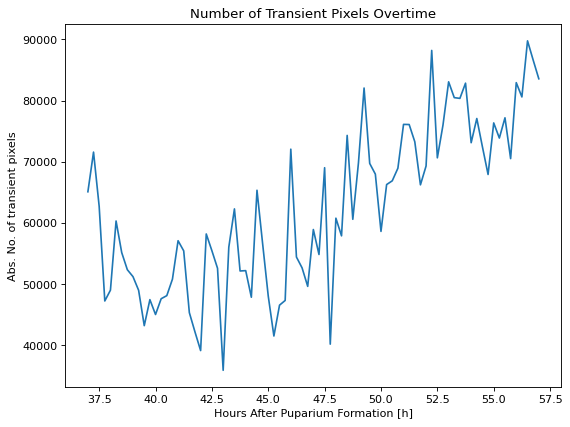

In [23]:
# calculating and plotting change (decrease) in transient pixels
img1 = neuron.astype('float64')
img2 = neuron_stable.astype('float64')
img2[img2 != 0] = 1
img1[img1 != 0] = 1

transient = []
for t in tqdm(np.arange(img2.shape[0]), desc='growth rate'):
    transient.append((img1[t].sum()-img2[t].sum()))

#ploting the results
from textwrap import wrap
timepoints = [37+(i*0.25) for i in np.arange(img2[4:].shape[0])]
y_val = transient[4:]
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(timepoints, y_val)
plt.title('Number of Transient Pixels Overtime')
plt.ylabel("\n".join(wrap('Abs. No. of transient pixels',30)))
plt.xlabel("Hours After Puparium Formation [h]")
plt.savefig('../output/Transient_pixels.pdf', bbox_inches='tight')

growth rate: 100%|██████████| 85/85 [00:49<00:00,  1.72it/s]


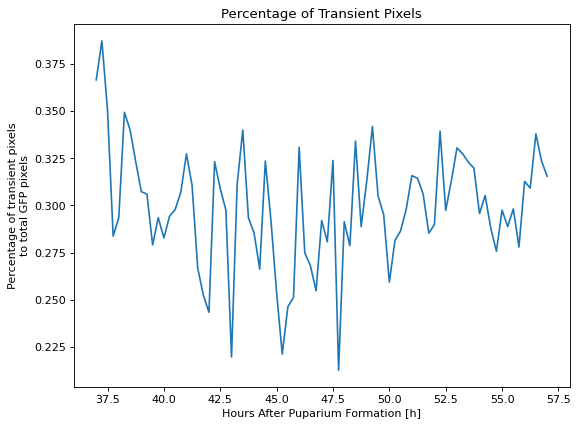

In [24]:
# calculating and plotting change (decrease) in transient pixels
img1 = neuron.astype('float64')
img2 = neuron_stable.astype('float64')
img2[img2 != 0] = 1
img1[img1 != 0] = 1

transient = []
for t in tqdm(np.arange(img2.shape[0]), desc='growth rate'):
    transient.append((img1[t].sum()-img2[t].sum())/img1[t].sum())

#ploting the results
from textwrap import wrap
timepoints = [37+(i*0.25) for i in np.arange(img2[4:].shape[0])]
y_val = transient[4:]
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(timepoints, y_val)
plt.title('Percentage of Transient Pixels')
plt.ylabel("\n".join(wrap('Percentage of transient pixels to total GFP pixels',30)))
plt.xlabel("Hours After Puparium Formation [h]")
plt.savefig('../output/Transient_pixels_percentage.pdf', bbox_inches='tight')

volume and growth_rate

100%|██████████| 85/85 [00:24<00:00,  3.54it/s]


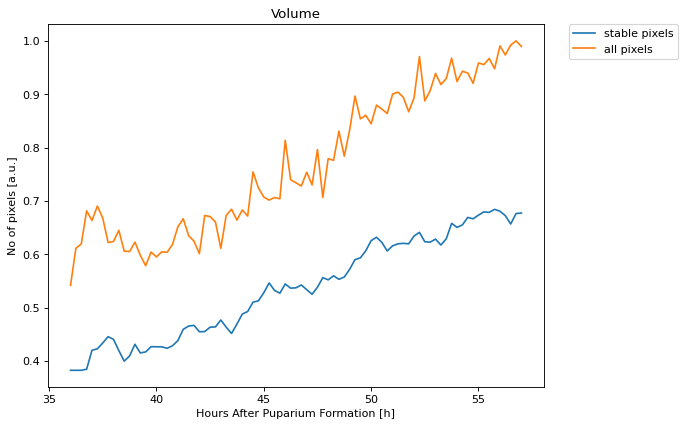

In [25]:
stable_sizes = []
for t in tqdm(np.arange(img2.shape[0])):
    stable_sizes.append(img2[t].sum())

all_sizes = []
for t in tqdm(np.arange(img1.shape[0])):
    all_sizes.append(img1[t].sum())

#ploting the results
from textwrap import wrap
timepoints = [36+(i*0.25) for i in np.arange(img2.shape[0])]
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(timepoints, stable_sizes/max(all_sizes), label='stable pixels')
plt.plot(timepoints, all_sizes/max(all_sizes), label='all pixels')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Volume')
plt.ylabel("\n".join(wrap('No of pixels [a.u.]',30)))
plt.xlabel("Hours After Puparium Formation [h]")
plt.savefig('../output/Size_Increase.pdf', bbox_inches='tight')

100%|██████████| 84/84 [00:00<00:00, 621378.37it/s]


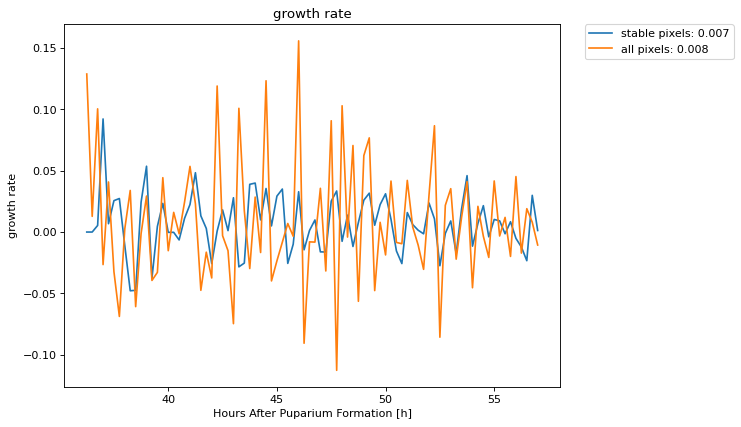

In [29]:
stable_growth = []
for t in tqdm(range(len(stable_sizes[1:]))):
    g = (stable_sizes[t+1]-stable_sizes[t])/stable_sizes[t]
    stable_growth.append(g)

all_growth = []
for t in tqdm(range(len(all_sizes[1:]))):
    g = (all_sizes[t+1]-all_sizes[t])/all_sizes[t]
    all_growth.append(g)

av_all = np.mean(all_growth)
av_st = np.mean(stable_growth)

#ploting the results
from textwrap import wrap
timepoints = [36.25+(i*0.25) for i in range(len(stable_growth))]
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(timepoints, stable_growth, label='stable pixels: '+"{:.3f}".format(av_st))
plt.plot(timepoints, all_growth, label='all pixels: '+"{:.3f}".format(av_all))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('growth rate')
plt.ylabel("\n".join(wrap('growth rate',30)))
plt.xlabel("Hours After Puparium Formation [h]")
plt.savefig('../output/growth_rate.pdf', bbox_inches='tight')

Distribution withing columns

calculating Col occupancy: 100%|██████████| 9/9 [00:00<00:00, 19.22it/s]


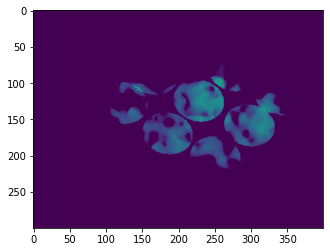

In [37]:
#### 2D representation of 3D_neuron distribution within columns

# load 3D neuron tif file (z,y,x)
img_path = '/Users/aichah/Documents/TLI_analysis/input_data/211011_neuron1_gfp_clean.tif'
with tif.TiffFile(img_path) as tiff:
    neuron = tiff.asarray()
neuron[neuron!=0] = 1 #make sure image is binary
neuron = neuron[-1]

# load columns mask as 3D stack: each column in a slice
col_path = '/Users/aichah/Documents/TLI_analysis/input_data/211011_neuron1_columns.tif'
# load image
with tif.TiffFile(col_path) as tiff:
    cols = tiff.asarray()
cols.shape
cols[cols!=0] = 1

# output figure
output = np.empty_like(neuron[0])

for col in tqdm(cols, desc='calculating Col occupancy'):
    filter = np.broadcast_to(col, neuron.shape)
    col_dist = filter * neuron
    output = output + col_dist

# make z_projection (sum axis0) and crop the output image if needed
output = output.sum(axis=0)
output = output[600:900,600:1000]
plt.imshow(output)